# Re-Modeling with New Data<a id='Re-Modeling_with_New_Data'></a>

### 1 Table of Contents<a id='Contents'></a>
* [Re-Modeling with New Data](#Re-Modeling_with_New_Data)
  * [1 Contents](#Contents)
  * [2 Introduction](#2_Introduction)
      * [2.1 Problem](#2.1_Problem)
      * [2.2 Data Sources](#2.2_Data_Sources)
  * [3 Imports](#3_Imports)
  * [4 Load Data](#4_Load_Data)
  * [5 Collecting and Merging](#5_Collecting_and_Merging)
      * [5.1 Attributes](#5.1_Attributes)
      * [5.2 Get NSRDB Data](#5.2_Get_NSRDB_Data)
          * [5.2.1 Scaling NSRDB Data](#5.2.1_Scaling_NSRDB_Data)
      * [5.3 Merging NSRDB Columns](#5.3_Merging_NSRDB_Columns)
      * [5.4 E.W. Brown Solar Data](#5.4_E.W._Brown_Solar_Data)
      * [5.5 Merge](#5.5_Merge)
  * [6 Clean and Explore](#6_Clean_and_Explore)
  * [7 Save Data](#7_Save_Data)
  * [8 Conclusion](#8_Conclusion)

### 2 Introduction<a id='2_Introduction'></a>

#### 2.1 Problem<a id='2.1_Problem'></a>

#### 2.2 Data Sources<a id='2.2_Data_Sources'></a>

### 3 Imports<a id='3_Imports'></a>

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.spatial import cKDTree
import h5pyd
import requests
import json
from requests.structures import CaseInsensitiveDict
from library.sb_utils import save_file

### 4 Load Data<a id='4_Load_Data'></a>

In [2]:
nsrdb = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2020.h5", 'r')
Attributes = pd.read_csv('../data/Attributes.csv', index_col = 'Unnamed: 0')
lat1 = 37.78820
lon1 = -84.71233
data = pd.read_csv('../raw_data/BS_2020.csv')

### 5 Collecting and Merging<a id='5_Collecting_and_Merging'></a>

#### 5.1 Attributes<a id='5.1_Attributes'></a>

In [3]:
Attributes.head()

,air_temperature,alpha,aod,asymmetry,cld_opd_dcomp,cld_reff_dcomp,clearsky_dhi,clearsky_dni,clearsky_ghi,cloud_press_acha,...,ozone,relative_humidity,solar_zenith_angle,ssa,surface_albedo,surface_pressure,time_index,total_precipitable_water,wind_direction,wind_speed
data_source,MERRA2,MERRA2,MERRA2,climatology,UW-GOES,UW-GOES,output,output,output,UW-GOES,...,MERRA2,derived,calculated,MERRA2,MODIS-IMS,MERRA2,NaN,MERRA2,MERRA2,MERRA2
elevation_correction,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,NaN,True,False,False
physical_max,70.0,2.5,1.5,1.0,80.0,80.0,800.0,1350.0,1350.0,1100.0,...,0.5,100.0,180.0,1.0,1.0,1100.0,NaN,15.0,360.0,40.0
physical_min,-100.0,0.0,0.01,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,300.0,NaN,0.0,0.0,0.0
psm_scale_factor,10.0,100.0,10000.0,100.0,100.0,100.0,1.0,1.0,1.0,1.0,...,1000.0,100.0,100.0,100.0,100.0,1.0,NaN,10.0,1.0,10.0


#### 5.2 Get NSRDB Data<a id='5.2_Get_NSRDB_Data'></a>

In [4]:
def getLocationData(lat, lon, cols = ['meta']):
    
    tree = cKDTree(nsrdb['coordinates'][...])
    dist, pos = tree.query(np.array([lat, lon]))
    
    df = pd.DataFrame(columns = cols)
    
    for col in cols:
        df[col] = nsrdb[col][:, pos]
    
    return df

In [5]:
columns1 = ['air_temperature', 'alpha', 'aod', 'asymmetry', 'cld_opd_dcomp', 'cld_reff_dcomp']
columns2 = ['clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'cloud_press_acha', 'cloud_type', 'dew_point']
columns3 = ['dhi', 'dni', 'ghi', 'ozone', 'relative_humidity', 'solar_zenith_angle', 'ssa', 'surface_albedo']
columns4 = ['surface_pressure', 'total_precipitable_water', 'wind_direction', 'wind_speed']

In [6]:
df1 = getLocationData(lat1, lon1, cols = columns1)

In [7]:
df2 = getLocationData(lat1, lon1, cols = columns2)

In [8]:
df3 = getLocationData(lat1, lon1, cols = columns3)

In [9]:
df4 = getLocationData(lat1, lon1, cols = columns4)

#### 5.2.1 Scaling NSRDB Data<a id='5.2.1_Scaling_NSRDB_Data'></a>

In [ ]:
for col in columns1:
    if (Attributes.loc['scale_factor', col]):
        scale = float(Attributes.loc['scale_factor', col])
        Weatherdf[col] = Weatherdf[col] / scale
for col in columns2:
    if (Attributes.loc['scale_factor', col]):
        scale = float(Attributes.loc['scale_factor', col])
        Weatherdf[col] = Weatherdf[col] / scale
for col in columns3:
    if (Attributes.loc['scale_factor', col]):
        scale = float(Attributes.loc['scale_factor', col])
        Weatherdf[col] = Weatherdf[col] / scale
for col in columns4:
    if (Attributes.loc['scale_factor', col]):
        scale = float(Attributes.loc['scale_factor', col])
        Weatherdf[col] = Weatherdf[col] / scale

#### 5.3 Merging NSRDB Columns<a id='5.3_Merging_NSRDB_Columns'></a>

In [10]:
Weatherdf = df1.merge(df2, left_index = True, right_index = True).merge(df3, left_index = True, right_index = True).merge(df4, left_index = True, right_index = True)

In [11]:
Weatherdf.head()

,air_temperature,alpha,aod,asymmetry,cld_opd_dcomp,cld_reff_dcomp,clearsky_dhi,clearsky_dni,clearsky_ghi,cloud_press_acha,...,ghi,ozone,relative_humidity,solar_zenith_angle,ssa,surface_albedo,surface_pressure,total_precipitable_water,wind_direction,wind_speed
0,22,129,860,61,0,0,0,0,0,0,...,0,346,8889,10729,97,12,984,9,270,19
1,21,129,860,61,0,0,0,0,0,0,...,0,346,8952,11304,97,12,984,10,271,19
2,20,129,930,61,0,0,0,0,0,0,...,0,345,8976,11887,97,12,984,10,272,19
3,18,129,930,61,0,0,0,0,0,0,...,0,346,9105,12477,97,12,984,10,272,19
4,17,131,920,61,0,0,0,0,0,0,...,0,346,9085,13069,97,12,984,10,271,19


#### 5.4 E.W. Brown Solar Data<a id='5.4_E.W._Brown_Solar_Data'></a>

In [12]:
data.head()

,Timestamp,Year,Month,Day,Hour,Minute,kW,kWh,POAI,GHI,TmpF,TmpC
0,2020-01-01 00:00:00,2020,1,1,0,0,-20.017269,65290968.0,-0.108067,-0.148322,37.411595,3.006442
1,2020-01-01 00:01:00,2020,1,1,0,1,-19.700493,65290968.0,-0.221178,-0.147710,37.410739,3.005966
2,2020-01-01 00:02:00,2020,1,1,0,2,-19.717964,65290968.0,-0.220839,-0.147098,37.409883,3.005491
3,2020-01-01 00:03:00,2020,1,1,0,3,-19.735436,65290968.0,-0.108067,-0.146486,37.409028,3.005015
4,2020-01-01 00:04:00,2020,1,1,0,4,-19.752909,65290968.0,-0.216135,-0.145874,37.408172,3.004540


#### 5.5 Merge<a id='5.5_Merge'></a>

In [14]:
Weatherdf['Timestamp'] = pd.date_range(start = "01/01/20 00:00:00", periods = Weatherdf.shape[0], freq = '30T')
Weatherdf['Year'] = Weatherdf['Timestamp'].agg(func = lambda x: x.year)
Weatherdf['Month'] = Weatherdf['Timestamp'].agg(func = lambda x: x.month)
Weatherdf['Day'] = Weatherdf['Timestamp'].agg(func = lambda x: x.day)
Weatherdf['Hour'] = Weatherdf['Timestamp'].agg(func = lambda x: x.hour)
Weatherdf['Minute'] = Weatherdf['Timestamp'].agg(func = lambda x: x.minute)

In [15]:
WeatherPower = Weatherdf.merge(data, how = 'inner', on = ['Year', 'Month', 'Day', 'Hour', 'Minute'])

In [16]:
WeatherPower.drop(columns = ['Timestamp_x', 'Timestamp_y', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace = True)

In [17]:
WeatherPower['Power'] = WeatherPower['kWh'].diff()
WeatherPower['Power'] = WeatherPower['Power'] / 0.5

In [18]:
WeatherPower.drop(columns = ['kW', 'kWh', 'POAI', 'GHI', 'TmpF', 'TmpC'], inplace = True)

#### 6 Clean and Explore<a id='6_Clean_and_Explore'></a>

In [ ]:
WeatherPower.dropna(inplace = True)

In [22]:
WeatherPower.dtypes

air_temperature             float64
alpha                       float64
aod                         float64
asymmetry                   float64
cld_opd_dcomp               float64
cld_reff_dcomp              float64
clearsky_dhi                float64
clearsky_dni                float64
clearsky_ghi                float64
cloud_press_acha            float64
cloud_type                  float64
dew_point                   float64
dhi                         float64
dni                         float64
ghi                         float64
ozone                       float64
relative_humidity           float64
solar_zenith_angle          float64
ssa                         float64
surface_albedo              float64
surface_pressure            float64
total_precipitable_water    float64
wind_direction              float64
wind_speed                  float64
Power                       float64
dtype: object

In [24]:
WeatherPower.head()

,air_temperature,alpha,aod,asymmetry,cld_opd_dcomp,cld_reff_dcomp,clearsky_dhi,clearsky_dni,clearsky_ghi,cloud_press_acha,...,ozone,relative_humidity,solar_zenith_angle,ssa,surface_albedo,surface_pressure,total_precipitable_water,wind_direction,wind_speed,Power
1,2.1,1.29,0.086,0.61,0.0,0.0,0.0,0.0,0.0,0.0,...,0.346,89.52,113.04,0.97,0.12,984.0,1.0,271.0,1.9,0.0
2,2.0,1.29,0.093,0.61,0.0,0.0,0.0,0.0,0.0,0.0,...,0.345,89.76,118.87,0.97,0.12,984.0,1.0,272.0,1.9,0.0
3,1.8,1.29,0.093,0.61,0.0,0.0,0.0,0.0,0.0,0.0,...,0.346,91.05,124.77,0.97,0.12,984.0,1.0,272.0,1.9,0.0
4,1.7,1.31,0.092,0.61,0.0,0.0,0.0,0.0,0.0,0.0,...,0.346,90.85,130.69,0.97,0.12,984.0,1.0,271.0,1.9,0.0
5,1.5,1.31,0.092,0.61,0.0,0.0,0.0,0.0,0.0,0.0,...,0.347,92.16,136.60,0.97,0.12,984.0,1.0,269.0,1.9,0.0


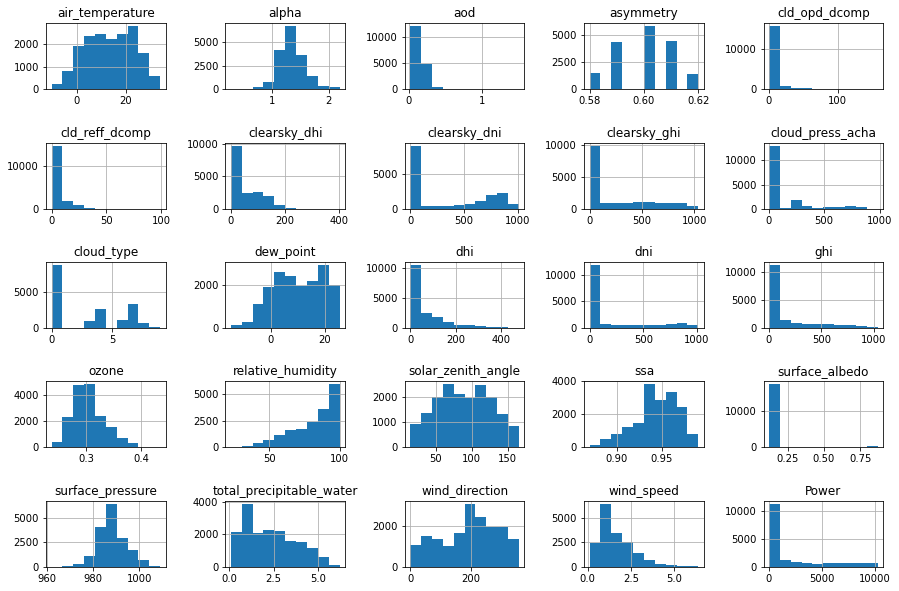

In [43]:
WeatherPower.hist(figsize = (15, 10))
plt.subplots_adjust(hspace=0.8, wspace = 0.5);

#### 7 Save Data<a id='7_Save_Data'></a>

In [ ]:
datapath = '../data'
save_file(WeatherPower, 'NewData.csv', datapath)

#### 8 Conclusion<a id='8_Conclusion'></a>